## LSTM Network predictions

In [ ]:
##create the classes and prepare the data
import os, sys

sys.path.append(os.path.abspath("../data_set_generator"))
sys.path.append(os.path.abspath("../network_training"))
sys.path.append(os.path.abspath("../data_preprocessing"))
sys.path.append(os.path.abspath("../data"))


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import keras
from keras import optimizers
from keras.models import Sequential
from data_set_generator.bike_prediction import DataGenerator
from data_set_generator.data_config import BikeDataConfig
from network_training.network_generator import NetworkGenerator
from network_training.callbacks import Callbacks

classes = 8
conf = BikeDataConfig(bikes_path = './/../data//bikes.csv', weather_path = './/../data//weather.csv', highest_class = classes)
FFN_logs_base_dir='./Modellcheckpoints/lstm/'
os.makedirs(FFN_logs_base_dir, exist_ok=True)
FFN_log_dir=os.path.join(FFN_logs_base_dir, '_LSTM.h5')
callbacks = Callbacks(filepath = FFN_log_dir)


batch_size = 256
input_dims = 11
output_dims = classes + 1 
sequence_length = 3
adam_optimizer = optimizers.Adam(learning_rate = 1e-4, beta_1=1- 1e-4, amsgrad = True)
sgd_optimizer = optimizers.SGD(learning_rate = 1e-2,  momentum = 0.9, nesterov = True)

network_gen = NetworkGenerator(data_generator = conf.d_gen, callbacks = callbacks, history_length = sequence_length)

2025-06-18 15:57:45.882701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create Batch Generators

In [ ]:
train_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.train_list_x,
                             y_data = network_gen.data_gen.train_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             random = False)

val_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.vali_list_x,
                             y_data = network_gen.data_gen.vali_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

test_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.test_list_x,
                             y_data = network_gen.data_gen.test_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

x_batch, y_batch = next(train_data_generator)
print(x_batch)
print(y_batch)

[[[ 0.77469835  0.54316378  0.         ...  0.         -0.94693013
   -0.32143947]
  [ 0.77469835  0.54316378  0.         ...  0.         -0.93969262
   -0.34202014]
  [ 0.77469835  0.54316378  0.         ...  0.         -0.93200787
   -0.36243804]]

 [[ 0.77468936  0.54317987  0.         ...  0.         -0.48098877
    0.87672676]
  [ 0.77468936  0.54317987  0.         ...  0.         -0.5
    0.8660254 ]
  [ 0.77468936  0.54317987  0.         ...  0.         -0.51877326
    0.85491187]]

 [[ 0.77468837  0.54314303  0.         ...  1.          0.32143947
    0.94693013]
  [ 0.77468837  0.54314303  0.         ...  1.          0.3007058
    0.95371695]
  [ 0.77468837  0.54314303  0.         ...  1.          0.27982901
    0.96004985]]

 ...

 [[ 0.77461529  0.54307175  0.         ...  1.          0.02181489
   -0.99976203]
  [ 0.77461529  0.54307175  0.         ...  1.          0.04361939
   -0.99904822]
  [ 0.77461529  0.54307175  0.         ...  1.          0.06540313
   -0.99785892]]

## Define and Generate a LSTM Network

In [3]:
lstm = Sequential()
lstm.add(keras.layers.LSTM(input_dims,
                     recurrent_dropout=0.5, 
                     return_sequences=True, 
                     input_shape = ( x_batch.shape[1], x_batch.shape[2] )  )
         )

lstm.add(keras.layers.LSTM(4*input_dims+1,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      activation = 'relu',
                      return_sequences=True)
          )

lstm.add(keras.layers.LSTM(4*input_dims+1,
                      dropout=0.1,
                      recurrent_dropout=0.5, 
                      activation = 'relu'
                      )
          )

lstm.add(keras.layers.Dense(output_dims, activation = 'softmax'))
lstm.summary()

network_gen.register_network(lstm)
network_gen.model.compile(optimizer = sgd_optimizer, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
results = network_gen.train_network(validation_data = val_data_generator, epochs = 25, train_data = train_data_generator)

/home/flo/python_environments/ml/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 11)          │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 45)          │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 45)             │        16,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,066 (109.63 KB)

 Trainable params: 28,066 (109.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.1695 - loss: 2.1185

/home/flo/python_projects/bike_forecast_kl/network_training/network_generator.py:91: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_batch[i][int(y_data.iloc[j])] = 1


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 229s 174ms/step - categorical_accuracy: 0.1696 - loss: 2.1184 - val_categorical_accuracy: 0.5882 - val_loss: 1.1177
Epoch 2/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.6830 - loss: 0.8999

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.6831 - loss: 0.8997 - val_categorical_accuracy: 0.8494 - val_loss: 0.5907
Epoch 3/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.8508 - loss: 0.5810

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.8508 - loss: 0.5810 - val_categorical_accuracy: 0.8666 - val_loss: 0.5436
Epoch 4/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.8808 - loss: 0.5016

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - categorical_accuracy: 0.8808 - loss: 0.5016 - val_categorical_accuracy: 0.8770 - val_loss: 0.5238
Epoch 5/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.8920 - loss: 0.4634

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - categorical_accuracy: 0.8920 - loss: 0.4634 - val_categorical_accuracy: 0.8793 - val_loss: 0.5012
Epoch 6/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.8996 - loss: 0.4430

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - categorical_accuracy: 0.8996 - loss: 0.4430 - val_categorical_accuracy: 0.8783 - val_loss: 0.4888
Epoch 7/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.9051 - loss: 0.4176

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9051 - loss: 0.4176 - val_categorical_accuracy: 0.8815 - val_loss: 0.4738
Epoch 8/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.9076 - loss: 0.4003

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9076 - loss: 0.4003 - val_categorical_accuracy: 0.8817 - val_loss: 0.4697
Epoch 9/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.9092 - loss: 0.3913

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - categorical_accuracy: 0.9092 - loss: 0.3913 - val_categorical_accuracy: 0.8822 - val_loss: 0.4665
Epoch 10/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9100 - loss: 0.3871

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 57s 44ms/step - categorical_accuracy: 0.9100 - loss: 0.3871 - val_categorical_accuracy: 0.8826 - val_loss: 0.4661
Epoch 11/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9126 - loss: 0.3777 - val_categorical_accuracy: 0.8824 - val_loss: 0.4705
Epoch 12/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.9140 - loss: 0.3741

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9140 - loss: 0.3741 - val_categorical_accuracy: 0.8829 - val_loss: 0.4614
Epoch 13/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.9157 - loss: 0.3685

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9157 - loss: 0.3685 - val_categorical_accuracy: 0.8829 - val_loss: 0.4550
Epoch 14/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9153 - loss: 0.3678 - val_categorical_accuracy: 0.8827 - val_loss: 0.4582
Epoch 15/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9156 - loss: 0.3652 - val_categorical_accuracy: 0.8834 - val_loss: 0.4586
Epoch 16/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9162 - loss: 0.3628

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9162 - loss: 0.3628 - val_categorical_accuracy: 0.8832 - val_loss: 0.4537
Epoch 17/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9164 - loss: 0.3604 - val_categorical_accuracy: 0.8829 - val_loss: 0.4567
Epoch 18/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9175 - loss: 0.3573 - val_categorical_accuracy: 0.8832 - val_loss: 0.4543
Epoch 19/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - categorical_accuracy: 0.9186 - loss: 0.3532 - val_categorical_accuracy: 0.8834 - val_loss: 0.4557
Epoch 20/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9182 - loss: 0.3537 - val_categorical_accuracy: 0.8836 - val_loss: 0.4541
Epoch 21/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9174 - loss: 0.3571

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9174 - loss: 0.3571 - val_categorical_accuracy: 0.8841 - val_loss: 0.4521
Epoch 22/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9186 - loss: 0.3525 - val_categorical_accuracy: 0.8839 - val_loss: 0.4554
Epoch 23/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9185 - loss: 0.3538 - val_categorical_accuracy: 0.8842 - val_loss: 0.4564
Epoch 24/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9189 - loss: 0.3523

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 55s 43ms/step - categorical_accuracy: 0.9189 - loss: 0.3523 - val_categorical_accuracy: 0.8849 - val_loss: 0.4509
Epoch 25/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9189 - loss: 0.3515

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - categorical_accuracy: 0.9189 - loss: 0.3515 - val_categorical_accuracy: 0.8844 - val_loss: 0.4497


## Print Training Results

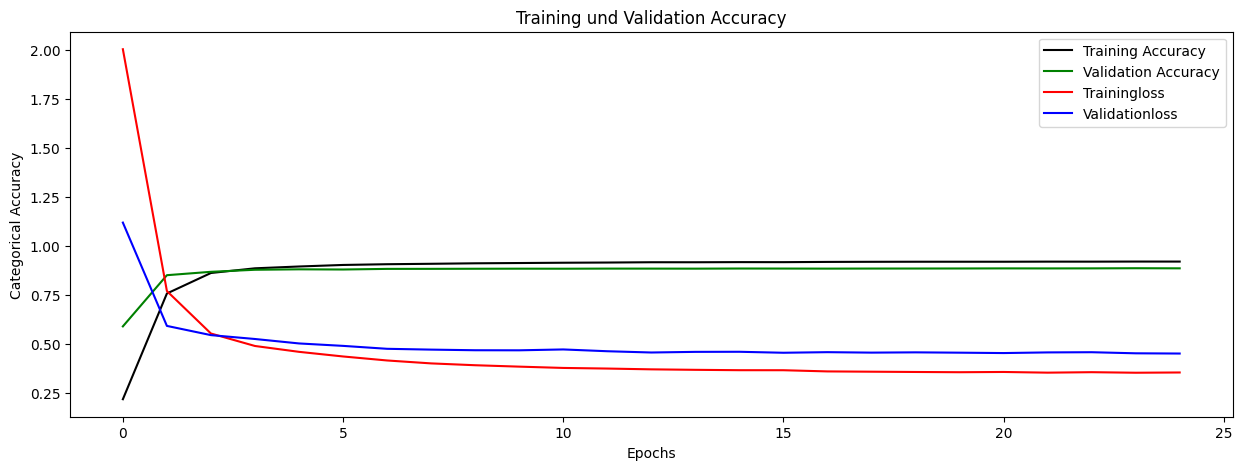

In [4]:
network_gen.print_training(results)

## Test Network and Create Metrics

In [5]:
x_batch, y_batch = next(test_data_generator)
network_gen.test_predictions(network_gen.model, x_batch, y_batch, True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 11)          │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 45)          │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 45)             │        16,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,134 (219.28 KB)

 Trainable params: 28,066 (109.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,068 (109.64 KB)

17597/17597 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - categorical_accuracy: 0.8965 - loss: 0.4111
17597/17597 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step
Confusion Matrix
[[ 84116   3560    523    111     27     10      4      1      3]
 [  3528  67966   3590    552     92     25     10      2      0]
 [   419   3388  55562   3293    491     80     21      6      4]
 [   105    487   3339  47006   2745    476    104     36     35]
 [    56    100    393   2662  39288   2673    407     82     88]
 [    18     52     91    382   2510  30213   3230    369    189]
 [    28     32     61    108    369   2267  25506   1945    609]
 [     6      9     20     32     64    300   2105  24120   2626]
 [    38     49     29     39     41     99    431   2165 135465]]
Klassifikations Report
0.9043817696503003
Akkuratheit der Klassifikation
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     88355
           1       0.90      0.90      0.90     75765
           2  